# Milestone Project 2: SkimLit 📄 🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the datatset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results are available here: https://arxiv.org/abs/1612.05251




In [ ]:
# Get our helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-01 10:28:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-01 10:28:38 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e83d2ce1-28f3-fcef-b024-723c79061b7c)


In [ ]:
# Lets import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from helper_functions import create_tensorboard_callback

## Get data

Since we'll be replicating the paper above (PubMed 200K RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
!git clone  https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip


In [ ]:
# Check what files are in the PubMed 20k dataset
# dev.txt is another word for validation set
!ls /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


In [ ]:
!unzip /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip

Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: train.txt               


In [ ]:
# Start our experiments using the 20K dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the file names in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess Data

Now'we got some text data, it's time to become one with it.

And one of the best way to become one with the data is to...

> Vizualize, Vizualize, Vizualize

So, with that in mind, let's write a function to read in all of the lines of our target text file.

In [ ]:
# Create function to read lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of the text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + 'train.txt') # read the lines within the training file
train_lines[:20]

FileNotFoundError: [Errno 2] No such file or directory: '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt'

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look like...

How I think our data would be best represented...
```
[{'line_number':0,
    'target': BACKGROUND,
    'text': 'Emotional eating is associated with overeating and the development of obesity .',
    'total_lines':11 },
...]
```

Let's write a function to turn our data in the above format.



In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# get data from file and preprocess it.
%%time
train_samples = preprocess_text_with_line_numbers('train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(test_samples), len(val_samples)

CPU times: user 3.97 s, sys: 1.04 s, total: 5.01 s
Wall time: 6.27 s


(2211861, 29493, 28932)

In [ ]:
train_samples[:10]

[{'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'line_number': 3,
  'total_lines': 10},
 {'target': 'METHODS',
  '

Now that our data is in the format of a list of dictionaries, how about we turn it into a dataframe to further visualize it.

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10


In [ ]:
train_df.to_csv('PubMed_200k_RCT_Numbers_replaced_with_@_train.csv')
val_df.to_csv('PubMed_200k_RCT_Numbers_replaced_with_@_dev.csv')
test_df.to_csv('PubMed_200k_RCT_Numbers_replaced_with_@_test.csv')

In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()
# A bit unbalanced for Objective

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

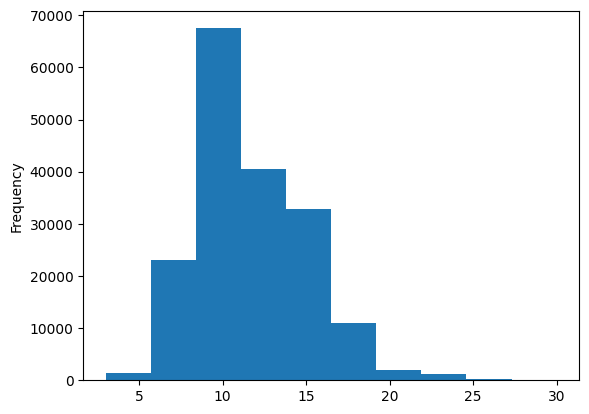

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

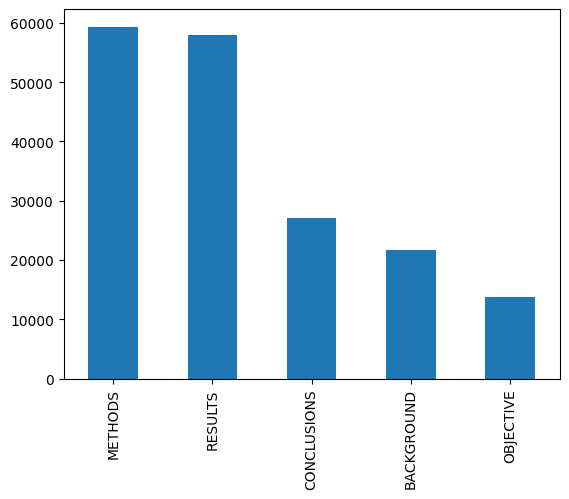

In [ ]:
# Let's check the distribution of labels
train_df['target'].value_counts().plot.bar();

### Getlist of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

### One Hot Encode the labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False) # we want a non-sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

# Check what one hot encoded labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encode labels

In [ ]:
# Extract labels ('target', columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# get class names and number of classes from LabelENcoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling Experiments (running a series of experiments)

Now we've got a way to turn our text sequences into numbers. It's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* `Model 0`. Tf-Idf encoder : Naive Bayes (Baseline) -> This is from sklearn ML map.
* `Model 1`. Feed forward Neural Network (dense model)
* `Model 2`. LSTM (RNN)
* `Model 3`. GRU (RNN)
* `Model 4`. Bidirectional-LSTM (RNN)
* `Model 5`. 1-D Convolutional Neural Network
* `Model 6`. Tensorflow-hub pretrained Feature Extraction
* `Model 7`. Tensorflow hub pretrained Feature Extractor (10%) of the data
How are we going to approach all of these? Use the standard steps in modelling with tensorflow:

1. Create a model
2. Build a model
3. Fit a model
4. Evaluate a model


In [ ]:
# Build the pipeline of baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()), # convert text into numbers
    ('multinomialNB', MultinomialNB())
])

# Fit the model
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('multinomialNB', MultinomialNB())])

In [ ]:
# Check the accuracy of the baseline model
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions on our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download the helper function script
In the previous model we wrote a function to compare predictions across different metrics (accuracy, precision, recall, F1-score) and rather than downloading it let's rewrite it here.

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
# let's create a helper function to compare different metrics across different models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_preds):
  """
  Returns a dictionary of all the metrics needed to compare the model.

  Args:
    y_true:
      Ground truth labels or actual labels

    y_pred:
      Labels predicted by the model.
  """
  # Let's calculate the metrics
  accuracy = accuracy_score(y_true, y_preds)
  precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_preds, average = 'weighted')

  metrics = {
      "accuracy" : accuracy,
      'precision' : precision,
      'recall': recall,
      'f1_score' : fscore
  }

  return metrics

In [ ]:
# Evaluate the baseline model predictions
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_preds = baseline_preds)
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

### Tokenize the train sentences

Before feeding the data into a deep model, we need to convert the text into numbers. We will do so by using the Tokenization function of sklearn.

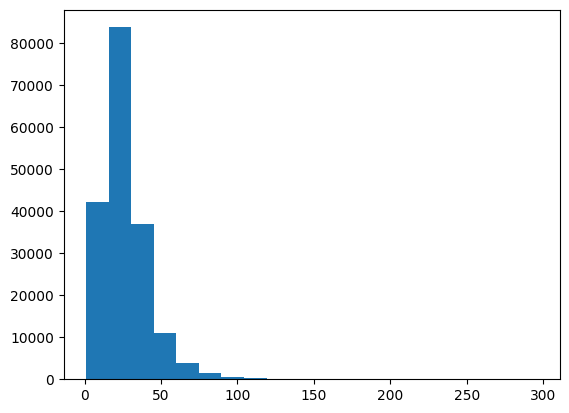

In [ ]:
# How long is each sentence in train sentences
import matplotlib.pyplot as plt
length = [len(word.split()) for word in train_sentences]
plt.hist(length, bins = 20);

In [ ]:
# How long of sentence length covers the 95 percent of the data?
output_seq_len = int(np.percentile(length, 95))
output_seq_len

55

A length of 55 words in a sentence covers 95 of the data.


In [ ]:
# Maximum sequence length in the training data
max(length)

296

In [ ]:
# Convert the text into numbers using the tokenization function

max_vocab_length = 68000

from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_vocab_length, # |V| vocabulary
                                    standardize = 'lower_and_strip_punctuation',
                                    split = 'whitespace',
                                    ngrams = None,
                                    output_mode = 'int',
                                    output_sequence_length = output_seq_len,
                                    pad_to_max_tokens = True
                                  )

# Adapt the text_vectorizer on our train_sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
text_vectorizer(['Hi, my name is Krutika'])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 6193, 25624,  9118,    20,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [ ]:
# Test our text vectorizer to training sentences
target_sentence = random.choice(train_sentences)
print(f'Text:\n {target_sentence}')
print(f'\nText Length: {len(target_sentence)}')
print(f'\nVectorized Text:\n{text_vectorizer([target_sentence])}')

Text:
 moxibustion can regulate blood lipids and clear blood vessels .

Text Length: 63

Vectorized Text:
[[1785  171 6604  107 2120    3 1545  107 3547    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# Get the unique words in the vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary() # Get all of the unique words in our training data found by the TextVectorizer
top_5_words = rct_20k_text_vocab[:5] # Get the most common words
bottom_5_words = rct_20k_text_vocab[-5:] # Get the least common words
print(f'Number of words in Vocab: {len(rct_20k_text_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in Vocab: 64841
5 most common words: ['', '[UNK]', 'the', 'and', 'of']
5 least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Create an Embedding layer

To make our embedding, we're going to use Tensorflow's Embedding layer.

* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, example, a value of 100 would mean each token gets represented by a vector 100 long.
* `input_length` = length of the sequences being passed to the embedding layer

In [ ]:
# Let's create a custom embedding layer
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim = len(rct_20k_text_vocab), # Length of vocabulary
                      output_dim = 128,
                      mask_zero = True, # Use masking to handle variable sequence lengths (save space)
                      name = 'token_embedding')

In [ ]:
# Check the embeddings on a sample sentence
print(f'Text before vectorization:\n{target_sentence}')
vectorized_text = text_vectorizer([target_sentence])
print(f'vectorized text :\n{vectorized_text}')
sample_embedding = embedding(vectorized_text)
print(f"Embedded text :\n{sample_embedding}")
print(f"Embedded text shape:{sample_embedding.shape}")

Text before vectorization:
moxibustion can regulate blood lipids and clear blood vessels .
vectorized text :
[[1785  171 6604  107 2120    3 1545  107 3547    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Embedded text :
[[[ 0.02995702  0.03344878  0.03734316 ...  0.04618906 -0.0354746
    0.01172173]
  [ 0.02663629 -0.0140462  -0.03605492 ...  0.00434918  0.00491083
    0.02501417]
  [ 0.01440043  0.03234181  0.04886469 ...  0.00163803  0.04460185
    0.01001291]
  ...
  [-0.03114103  0.03995493  0.03878328 ... -0.00731944 -0.02433952
    0.04266998]
  [-0.03114103  0.03995493  0.03878328 ... -0.00731944 -0.02433952
    0.04266998]
  [-0.03114103  0.03995493  0.03878328 ... -0.00731944 -0.02433952
    0.04266998]]]
Embedded text shape:(1, 55, 128)


The output shape of embedding
```
The shape of the embedded text output is: (1, 55, 128)
1 = number of sentences being inputted
55 = it is the number of tokens in input sequence
128 = these are number of features created for each token. It is represented using a 128 long vector  
```

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible wiht the TensorFlow tf.data API, many of the steps here are discussed in the below resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
# Take these datasets and turn them into prefetched datasets
# We are not trying to shuffle because the order of the data is important in our data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D Deep model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Lets build the Conv1D model using the functional API
inputs = layers.Input(shape = (1, ), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation = 'softmax')(x)

model_1 = tf.keras.Model(inputs, outputs, name = 'model_1_conv1d')

In [ ]:
model_1.summary()

Model: "model_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                    

In [ ]:
# COmpile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)), # only validate on 10% of batches
                              callbacks = [create_tensorboard_callback(dir_name = 'model_logs',
                                                                       experiment_name = 'model_1_conv1d')])

Saving TensorBoard log files to: model_logs/model_1_conv1d/20240131-093511
Epoch 1/3
5627/5627 [==============================] - 59s 10ms/step - loss: 0.6122 - accuracy: 0.7769 - val_loss: 0.5430 - val_accuracy: 0.8005
Epoch 2/3
5627/5627 [==============================] - 35s 6ms/step - loss: 0.4514 - accuracy: 0.8418 - val_loss: 0.5376 - val_accuracy: 0.8015
Epoch 3/3
5627/5627 [==============================] - 35s 6ms/step - loss: 0.3704 - accuracy: 0.8733 - val_loss: 0.5697 - val_accuracy: 0.8012


In [ ]:
# Lets evaluate the model
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5668 - accuracy: 0.8061


[0.566767692565918, 0.806103527545929]

In [ ]:
# make some predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs[:10]

945/945 [==============================] - 3s 3ms/step


array([[6.9241440e-01, 1.2405364e-02, 2.3571965e-01, 3.2897990e-02,
        2.6562611e-02],
       [6.1744213e-01, 4.5614358e-02, 4.1126981e-03, 3.2504487e-01,
        7.7858483e-03],
       [1.2387849e-01, 3.7480141e-03, 1.6435131e-03, 8.7061328e-01,
        1.1668371e-04],
       [1.0299993e-05, 1.7340748e-05, 9.9763632e-01, 6.2653994e-06,
        2.3297952e-03],
       [2.7207437e-03, 2.0678975e-02, 7.2632569e-01, 1.8265581e-03,
        2.4844801e-01],
       [9.1165572e-04, 6.1997294e-04, 8.8345087e-01, 4.0315677e-04,
        1.1461436e-01],
       [2.0963262e-05, 1.5948943e-04, 3.1098995e-01, 1.0631721e-05,
        6.8881899e-01],
       [1.8921149e-03, 2.5117493e-03, 5.0765014e-01, 5.3826935e-04,
        4.8740771e-01],
       [9.4626740e-14, 4.0042374e-09, 1.6160795e-08, 4.2807361e-14,
        1.0000000e+00],
       [3.5539101e-04, 8.9474612e-01, 8.3245145e-04, 1.8991207e-04,
        1.0387615e-01]], dtype=float32)

In [ ]:
# Convert pred probs into classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 2, 4, 2, 4, 1])>

In [ ]:
# Calculate the model 1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_preds = model_1_preds)
model_1_results

{'accuracy': 0.8061035350191976,
 'precision': 0.8031667144778463,
 'recall': 0.8061035350191976,
 'f1_score': 0.8034261359695938}

## Model 2: Feature Extraction using pretrained token embeddings

In [ ]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                         trainable = False,
                                         name = 'Universal_sentence_encoder')

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'sentence after the embedding:\n {use_embedded_sentence[0][:30]}')
print(f"length of sentence embedding: {len(use_embedded_sentence[0])}")

random sentence:
 in preclinical models , the egfr inhibitor azd@ has been shown to be effective against both egfr tyrosine kinase inhibitor-sensitizing and t@m resistance mutations .
sentence after the embedding:
 [ 0.04281975  0.00019446 -0.04923575 -0.03687417 -0.02545469  0.07158113
 -0.04668127 -0.04135401 -0.01861258  0.01955072  0.08996057 -0.06865275
  0.0515687   0.06425299 -0.02761993 -0.04370596 -0.07851037 -0.01586823
  0.0774914   0.01053136 -0.00291659 -0.07165693 -0.06007925  0.02529221
  0.06301214  0.07015345  0.04002282  0.00092535 -0.04785905  0.08232114]
length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow hub

In [ ]:
# Let's build the tensorflow hub pretrained USE model
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embeddings = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = 'relu')(pretrained_embeddings)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_2 = tf.keras.Model(inputs,
                         outputs,
                         name = 'model_2_pretrained')

In [ ]:
# compile the model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
# fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 *len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 19s 26ms/step - loss: 0.9213 - accuracy: 0.6490 - val_loss: 0.7962 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7692 - accuracy: 0.7012 - val_loss: 0.7550 - val_accuracy: 0.7025
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7543 - accuracy: 0.7122 - val_loss: 0.7408 - val_accuracy: 0.7148


In [ ]:
# Evaluate the model_2
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7430 - accuracy: 0.7124


[0.742965817451477, 0.7124321460723877]

In [ ]:
# Lets functionize converting model predictions to labels
def convert_preds_to_labels(model, dataset):
  """
  Returns the converted predicted probabilties into labels.
  """
  pred_probs = model.predict(dataset)
  pred_labels = tf.argmax(pred_probs, axis = 1)

  return pred_labels

In [ ]:
# convert the prediction probabilties into labels
model_2_preds = convert_preds_to_labels(model_2, valid_dataset)
model_2_preds

945/945 [==============================] - 10s 10ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate model_2 results
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_preds = model_2_preds)
model_2_results

{'accuracy': 0.712432146167086,
 'precision': 0.7125210268760483,
 'recall': 0.712432146167086,
 'f1_score': 0.7092516529154183}

In [ ]:
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

In [ ]:
model_1_results

{'accuracy': 0.8061035350191976,
 'precision': 0.8031667144778463,
 'recall': 0.8061035350191976,
 'f1_score': 0.8034261359695938}

### Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character level tokenizer

In [ ]:
# make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-charcter-level sequence into characters
split_chars(random_train_sentence)

'i n   p r e c l i n i c a l   m o d e l s   ,   t h e   e g f r   i n h i b i t o r   a z d @   h a s   b e e n   s h o w n   t o   b e   e f f e c t i v e   a g a i n s t   b o t h   e g f r   t y r o s i n e   k i n a s e   i n h i b i t o r - s e n s i t i z i n g   a n d   t @ m   r e s i s t a n c e   m u t a t i o n s   .'

In [ ]:
# Split sequence level data splits into character level dara splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# Whats the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

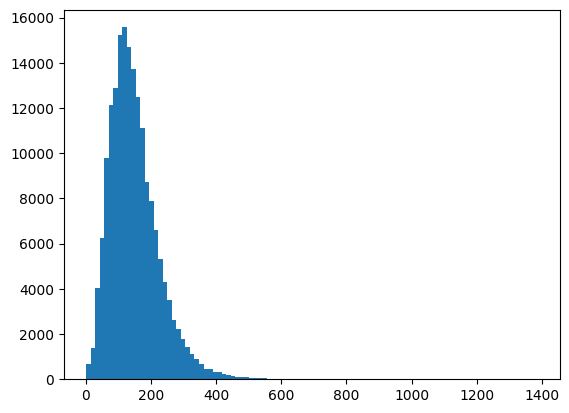

In [ ]:
# Check the distribution of our sequences at a charcter level
plt.hist(char_lens, bins = 100);

In [ ]:
# Find what character length convers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet =  string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
len(alphabet)

68

In [ ]:
max(char_lens), min(char_lens)

(1386, 1)

In [ ]:
# Create char level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocabulary -> [UNK])
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    #standardize = None, # set standardization to None if you want to leave punctuation in
                                    output_sequence_length = output_seq_char_len,
                                    name = 'char_vectorizer')

# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in charcter vocab: {len(char_vocab)}')
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in charcter vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'charified text:\n {random_train_chars}')
print(f'\nlength of random_train_chars: {len(random_train_chars)}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nvectorized chars:\n{vectorized_chars}')
print(f'\nlength of vectorized chars: {len(vectorized_chars[0])}')

charified text:
 t w e l v e   s f - p c d   a n d   @   f a r m - r a i s e d   s i b l i n g s   w e r e   v a c c i n a t e d   o n   d a y   @   (   d @   )   a n d   d @   o f   a g e   .

length of random_train_chars: 175

vectorized chars:
[[ 3 20  2 12 21  2  9 17 14 11 10  5  6 10 17  5  8 15  8  5  4  9  2 10
   9  4 22 12  4  6 18  9 20  2  8  2 21  5 11 11  4  6  5  3  2 10  7  6
  10  5 19 10  5  6 10 10  7 17  5 18  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0

### Creating a character level embedding

In [ ]:
# Create char embedding layer
from tensorflow.keras.layers import Embedding
char_embed = Embedding(input_dim = len(char_vocab),
                       output_dim = 25, # this is the size of the char embedding in the paper: 1612.05251
                       mask_zero = True,
                       name = 'char_embed')

In [ ]:
# Text our charcter embedding layer
print(f"charified text:\n {random_train_chars}\n")
char_embed_sample = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding:\n {char_embed_sample}")
print(f'\ncharacter embedding shape: {char_embed_sample.shape}')

charified text:
 t w e l v e   s f - p c d   a n d   @   f a r m - r a i s e d   s i b l i n g s   w e r e   v a c c i n a t e d   o n   d a y   @   (   d @   )   a n d   d @   o f   a g e   .

Embedded chars. (after vectorization and embedding:
 [[[-0.03566549 -0.02396467  0.03281573 ... -0.01300547 -0.04275285
   -0.01114221]
  [-0.0213287   0.03607189  0.00111355 ...  0.04046332 -0.04259949
   -0.02968924]
  [-0.01805528 -0.04772543  0.00650364 ...  0.046309   -0.00542028
    0.02287434]
  ...
  [ 0.02581943 -0.029986   -0.00034881 ...  0.02346649 -0.02517398
    0.00132172]
  [ 0.02581943 -0.029986   -0.00034881 ...  0.02346649 -0.02517398
    0.00132172]
  [ 0.02581943 -0.029986   -0.00034881 ...  0.02346649 -0.02517398
    0.00132172]]]

character embedding shape: (1, 290, 25)


Character embedding output:
```
* 1 = No. of sequences
* 290 = output sequence length
* 25 = no of features created for each character
```

## Creating character level fast performant Datasets

In [ ]:
# Create char level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))
train_char_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Creating batched/ prefetched dataset for faster data loading
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 3: Building a Conv1D model using the character level embedding

In [ ]:
# Build COnv1D model using character level embedding
inputs = layers.Input(shape = [], dtype = tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name = 'model_3_char_conv1D')

In [ ]:
# COmpile the model
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3_char_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)         

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2536 - accuracy: 0.4861 - val_loss: 1.0398 - val_accuracy: 0.5891
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 1.0057 - accuracy: 0.5982 - val_loss: 0.9322 - val_accuracy: 0.6320
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9231 - accuracy: 0.6377 - val_loss: 0.8633 - val_accuracy: 0.6553


In [ ]:
# Make predictions with charcter model
model_3_preds = convert_preds_to_labels(model_3, val_char_dataset)
model_3_preds

945/945 [==============================] - 3s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [ ]:
# Calculate results for mmodel_3
model_3_char_results = calculate_results(y_true = val_labels_encoded,
                                         y_preds = model_3_preds)
model_3_char_results

{'accuracy': 0.6588110684496227,
 'precision': 0.6534519784841677,
 'recall': 0.6588110684496227,
 'f1_score': 0.649571599490439}

## Model 4: Combining pretrained token embeddings + characters Embedding

1. Create a token level embedding model ( similar `model_1`)
2. Create a character level model (similar `model_3`)
3. Combine 1 & 2 with a concatenate (`laters.Concatenate`)
4. Build a series of output layers on top of 3 similar to figure 1 and section 4.2 of the paper 1612.05251
5. Construct a model which takes token and charcter level sequences as input and produces sequence label probabilities as output.


In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs,
                             name = 'token_embedding')

# 2. Setup char inputs/model
char_inputs = layers.Input(shape = [], dtype = tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # Bi LSTM according to the paper we are following 1612.051251
char_model = tf.keras.Model(inputs = char_inputs,
                              outputs = char_bi_lstm,
                              name = 'char_embedding')

# 3. Concatenate token and char inputs ( create hybrid token embedding)
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                    char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'Model_4_token_and_char_embeddings')

In [ ]:
# Get a sumaary of our model
model_4.summary()

Model: "Model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['input_4[0][0]']             
 rization)                                                                                        
                                                                                                  
 Universal_sentence_encoder  (None, 512)                  2567978 

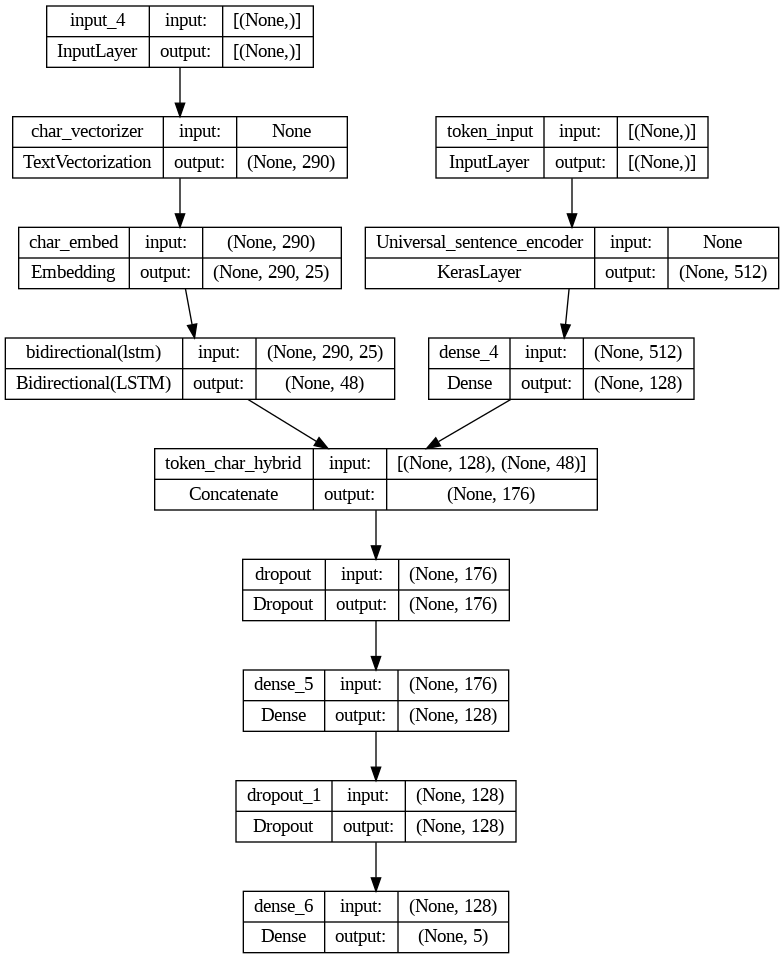

In [ ]:
# plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [ ]:
# Compile the token char model
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

### Combining token and character data into tf.data.Dataset

In [ ]:
train_sentences[:2]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .']

In [ ]:
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [ ]:
# # Combine chars and tokens into a dataset
# train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
# train_token_char_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
# train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

# # Prefetch and batch train data
# train_char_token_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# let's functionize the above operation so that we don't need to rewrite the code
def combine_char_token_dataset(token_dataset, char_dataset, label_dataset, tribrid = False, total_line_data = None, line_num_data = None):
  """
  Returns a prefetched and batched combined token and character dataset with labels.
  """
  if tribrid == False:
    combined_token_char_data = tf.data.Dataset.from_tensor_slices((token_dataset,
                                                                  char_dataset))
    combined_token_char_labels = tf.data.Dataset.from_tensor_slices((label_dataset))
    combined_token_char_dataset_with_labels = tf.data.Dataset.zip((combined_token_char_data, combined_token_char_labels))

  else:
    combined_token_char_pos_data = tf.data.Dataset.from_tensor_slices((line_num_data,
                                                                   total_line_data,
                                                                   token_dataset,
                                                                   char_dataset))

    combined_token_char_labels = tf.data.Dataset.from_tensor_slices((label_dataset))

    combined_token_char_dataset_with_labels = tf.data.Dataset.zip((combined_token_char_pos_data, combined_token_char_labels))


  # Prefetch and batch the combined data
  combined_dataset = combined_token_char_dataset_with_labels.batch(32).prefetch(tf.data.AUTOTUNE)

  return combined_dataset

In [ ]:
# Get a prefetched and batched combined token and character train data
train_char_token_dataset = combine_char_token_dataset(token_dataset = train_sentences,
                                                      char_dataset = train_chars,
                                                      label_dataset = train_labels_one_hot)
train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Get a prefetched and batched combined token and character validation data
val_char_token_dataset = combine_char_token_dataset(token_dataset = val_sentences,
                                                    char_dataset = val_chars,
                                                    label_dataset = val_labels_one_hot)
val_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Get a prefetched and batched combined token and character test data
test_char_token_dataset = combine_char_token_dataset(token_dataset = test_sentences,
                                                     char_dataset = test_chars,
                                                     label_dataset = test_labels_one_hot)
test_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 54ms/step - loss: 0.9837 - accuracy: 0.6088 - val_loss: 0.7765 - val_accuracy: 0.6975
Epoch 2/3
562/562 [==============================] - 25s 44ms/step - loss: 0.8016 - accuracy: 0.6906 - val_loss: 0.7145 - val_accuracy: 0.7301
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.7747 - accuracy: 0.7061 - val_loss: 0.6960 - val_accuracy: 0.7354


In [ ]:
# evaluate the model
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.7023 - accuracy: 0.7320


[0.7023200392723083, 0.732026994228363]

In [ ]:
# Make some predictions
model_4_preds = convert_preds_to_labels(model_4, val_char_token_dataset)
model_4_preds

945/945 [==============================] - 21s 19ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [ ]:
# calculate the model results
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

{'accuracy': 0.7320270091354428,
 'precision': 0.7349326277847071,
 'recall': 0.7320270091354428,
 'f1_score': 0.7291315524196494}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑 **Note**: Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

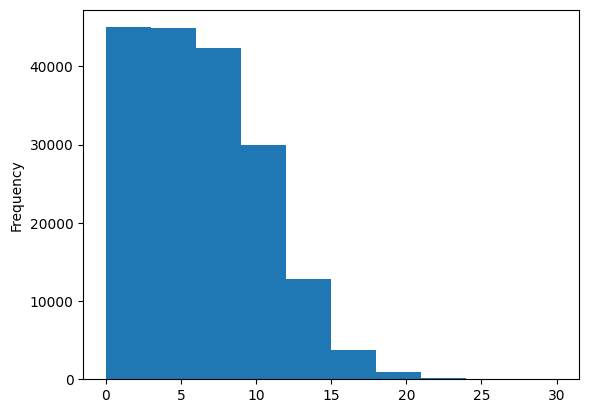

In [ ]:
# Check the distribution of the line number column
train_df.line_number.plot.hist();

In [ ]:
# Use tensorflow to create one-hot-encoded tensors of our line number column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)

train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers features, let's do the same for our total lines feature..

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# how many different no of total_lines are there
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

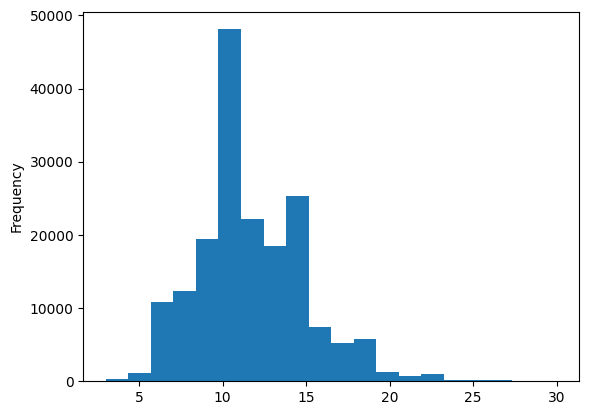

In [ ]:
# check the distribution of total_lines column
train_df['total_lines'].plot.hist(bins = 20);

In [ ]:
# check the coverage of a total lines that covers 95% of the data
np.percentile(train_df['total_lines'], 98)

20.0

In [ ]:
# Use the TensorFlow to create one hot encoded tensors of our total_features
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a Tribrid Embedding model

1. Create a token-level model
2. Create a character level model
3. Create a model for the "line_number" feature
4. Create a model for "total_lines" feature
5. Combine the outputs of 1 & 2 using the `tf.keras.layers.Concatenate`
6. Cnmbine the outputs of 3, 4, 5 using the `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label predictions
8. Combine the inputs of 1, 2, 3 & 4 and the outputs of 7 into a `tf.keras.Model`

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape = [], dtype = 'string', name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = [], dtype = 'string', name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(64))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_outputs)

# 3. Line number inputs
line_number_inputs = layers.Input(shape = (train_line_numbers_one_hot.shape[1],), dtype = tf.float32, name = 'line_number_inputs')
line_number_outputs = layers.Dense(32, activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = line_number_outputs)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape = (train_total_lines_one_hot.shape[1],), dtype = tf.float32, name = 'total_lines_inputs')
total_lines_outputs = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = total_lines_outputs)

# 5. Combine token and char embeddings into a hybrid embedding model
combined_embeddings = layers.Concatenate(name = 'token_char_hybrid_model')([token_model.output,
                                                                            char_model.output])
z = layers.Der_token_positional')([line_number_model.output,
                                                                        total_lines_model.output,
                                                                        combined_embeddings_output])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.inputs,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = "tribrid_embedding_model")

In [ ]:
# Get a summary of our tribrid model
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 Universal_sentence_encoder  (None, 512)                  2567978   ['token_

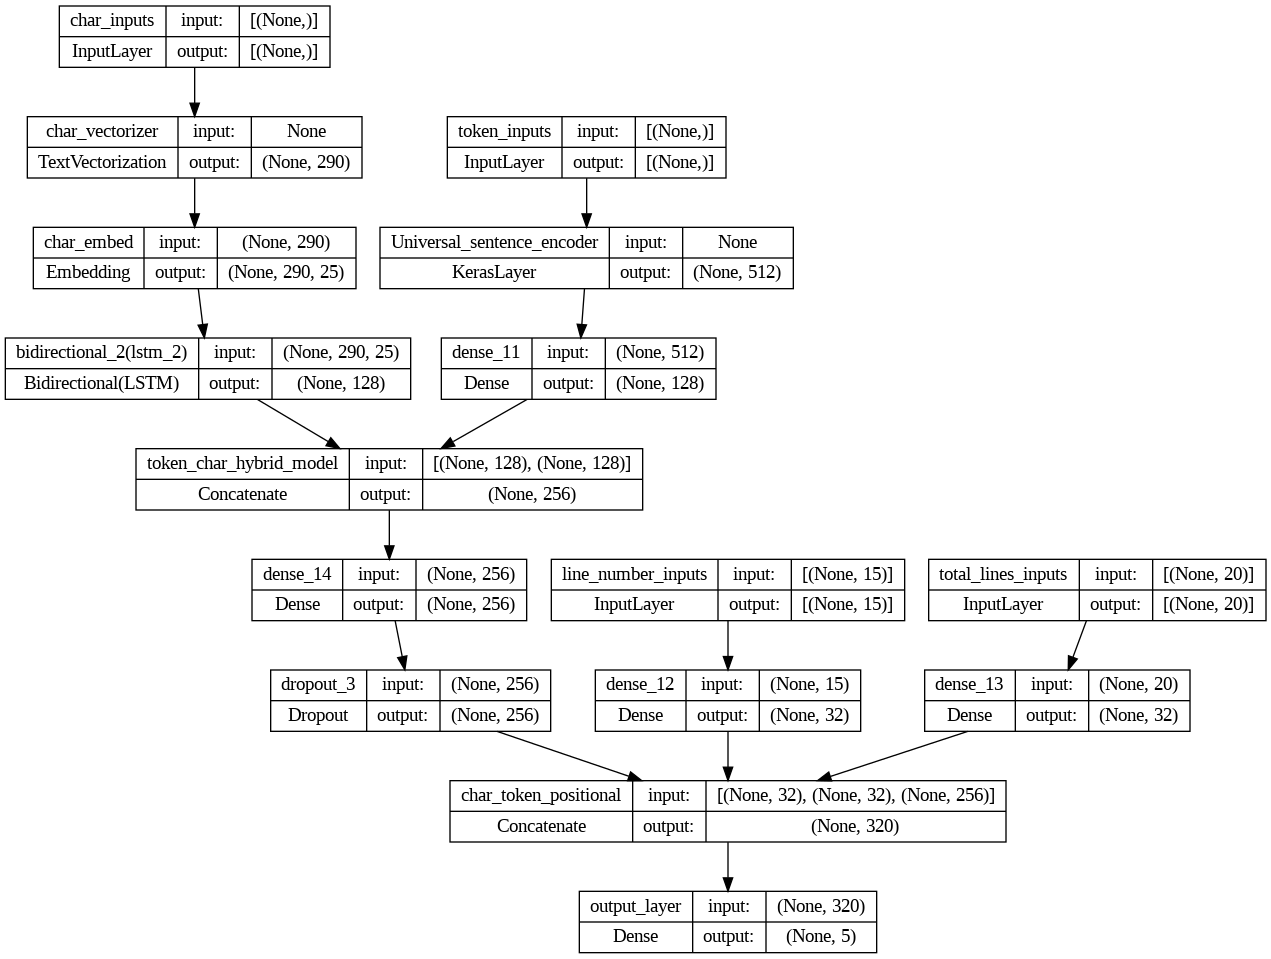

In [ ]:
# plot the tribrid model architecture
from keras.utils import plot_model
plot_model(model_5, show_shapes = True)

What is label smoothening?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.9, 0.01, 0.01]`


> 📖 Resource : For more on label smoothing : https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# Compile the model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),# helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Creating tribrid embedding datasets

In [ ]:
# Create training and validation datasets(with all four kinds of input data)
train_char_token_pos_dataset = combine_char_token_dataset(token_dataset = train_sentences,
                                                          char_dataset = train_chars,
                                                          label_dataset = train_labels_one_hot,
                                                          tribrid = True,
                                                          total_line_data = train_total_lines_one_hot,
                                                          line_num_data = train_line_numbers_one_hot)
train_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Create training and validation datasets(with all four kinds of input data)
val_char_token_pos_dataset = combine_char_token_dataset(token_dataset = val_sentences,
                                                        char_dataset = val_chars,
                                                        label_dataset = val_labels_one_hot,
                                                        tribrid = True,
                                                        total_line_data = val_total_lines_one_hot,
                                                        line_num_data = val_line_numbers_one_hot)
val_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Create training and validation testing datasets(with all four kinds of input data)
test_char_token_pos_dataset = combine_char_token_dataset(token_dataset = test_sentences,
                                                         char_dataset = test_chars,
                                                         label_dataset = test_labels_one_hot,
                                                         tribrid = True,
                                                         total_line_data = test_total_lines_one_hot,
                                                         line_num_data = test_line_numbers_one_hot)
test_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
train_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
# Fit the tribrid model
model_5_history = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1 * len(train_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 53s 76ms/step - loss: 0.9555 - accuracy: 0.8215 - val_loss: 0.9411 - val_accuracy: 0.8273
Epoch 2/3
562/562 [==============================] - 42s 75ms/step - loss: 0.9337 - accuracy: 0.8379 - val_loss: 0.9288 - val_accuracy: 0.8402
Epoch 3/3
562/562 [==============================] - 59s 105ms/step - loss: 0.9359 - accuracy: 0.8355 - val_loss: 0.9239 - val_accuracy: 0.8399


In [ ]:
# Evaluate results on our tribrid model
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 35s 37ms/step - loss: 0.9276 - accuracy: 0.8379


[0.9275945425033569, 0.8379120826721191]

In [ ]:
# Make predictions and convert the probabilities
model_5_preds = convert_preds_to_labels(model_5, val_char_token_pos_dataset)
model_5_preds

945/945 [==============================] - 29s 25ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_preds = model_5_preds)
model_5_results

{'accuracy': 0.8379120879120879,
 'precision': 0.8371502231919563,
 'recall': 0.8379120879120879,
 'f1_score': 0.8370925652284898}

## Comparing the results of all our modelling experiments

In [ ]:
# Combine the mdoel results into a DataFrame
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding_conv1d': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_char_results,
                                  'model_4_hybrid_char_token_embedding': model_4_results,
                                  'model_5_pos_char_token_embedding': model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1_score
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding_conv1d,0.806104,0.803167,0.806104,0.803426
model_2_pretrained_token_embedding,0.712432,0.712521,0.712432,0.709252
model_3_custom_char_embedding,0.658811,0.653452,0.658811,0.649572
model_4_hybrid_char_token_embedding,0.732027,0.734933,0.732027,0.729132
model_5_pos_char_token_embedding,0.837912,0.837150,0.837912,0.837093


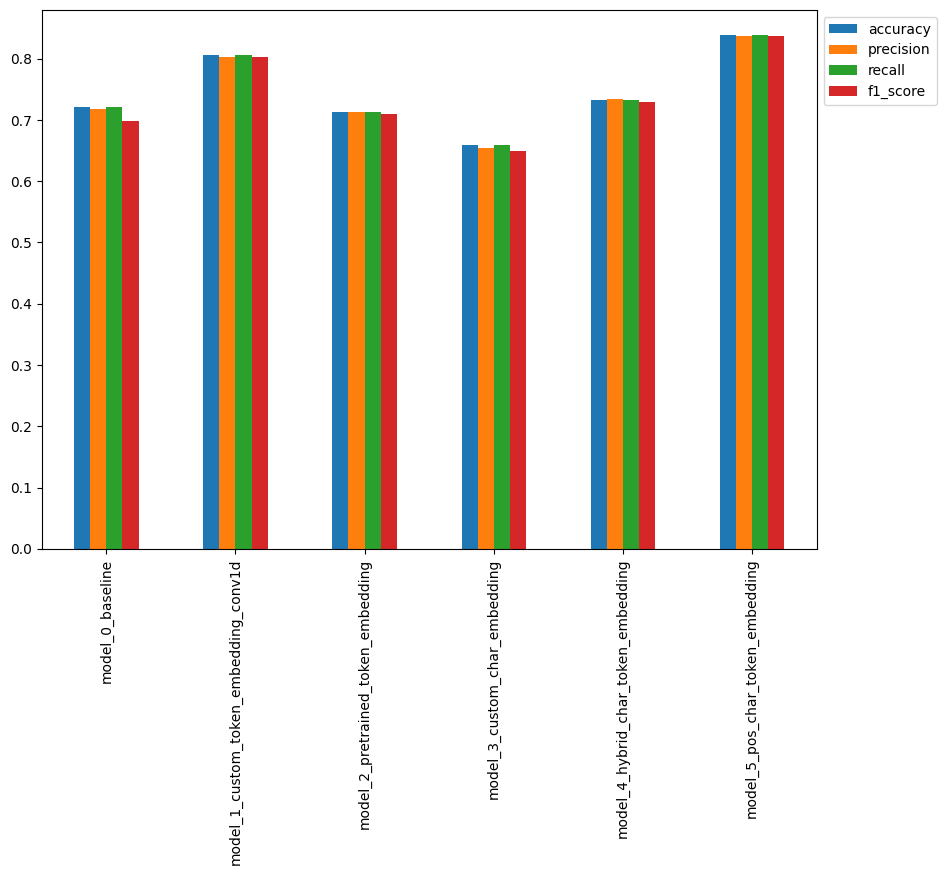

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind = 'bar', figsize = (10,7)).legend(bbox_to_anchor = (1.0, 1.0));

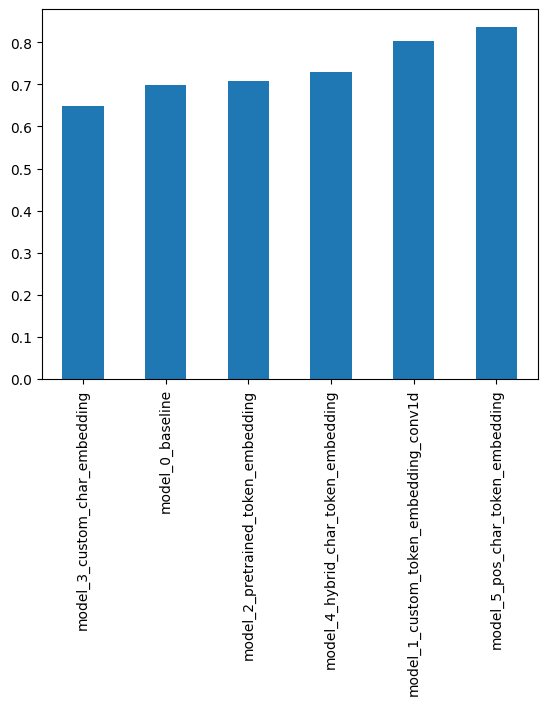

In [ ]:
# Sort model results by the F1-score
all_model_results.sort_values('f1_score', ascending = True)['f1_score'].plot(kind = 'bar');

## Save and load Model

In [ ]:
# save our best performing model
model_5.save('model_5')

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model('model_5')

In [ ]:
# make some predictions on loaded model
loaded_model_preds = convert_preds_to_labels(loaded_model, val_char_token_pos_dataset)

945/945 [==============================] - 22s 20ms/step


In [ ]:
# Model 5 results
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_preds = loaded_model_preds)
loaded_model_results

{'accuracy': 0.8379120879120879,
 'precision': 0.8371502231919563,
 'recall': 0.8379120879120879,
 'f1_score': 0.8370925652284898}

In [ ]:
model_5_results

{'accuracy': 0.8379120879120879,
 'precision': 0.8371502231919563,
 'recall': 0.8379120879120879,
 'f1_score': 0.8370925652284898}

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
# Check the loaded model summary
loaded_model.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 Universal_sentence_encoder  (None, 512)                  2567978   ['token_

In [ ]:
from google.colab import files
files.download('model_5')

In [ ]:
!cp -r /content/model_5 /content/drive/MyDrive/Saved_models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
